# p-n junctions
This notebook gives a tutorial for numerical simulations on p-n junctions using the Sesame python package. 

In [67]:
%matplotlib widget
# Handle relative import
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import sesame
import numpy as np
import scipy.constants as cts
import json
import matplotlib.pyplot as plt
from shlib import to_path, mkdir
# To set matplotlib colors:
import matplotlib as mpl
from cycler import cycler
matplotcolors = ['k', 'r', 'g', 'b', 'c', 'm', 'y']
mpl.rcParams['axes.prop_cycle'] = cycler(color=matplotcolors)
root = to_path(os.path.abspath(''))
gzip_dir = to_path(root, 'gzip')
mkdir(gzip_dir)

## Physical constants
Define some useful physical constants

In [68]:
T = 300 # Temp [K]
kB_si = cts.k # Boltzmann in si units
q = cts.e # Electron charge
epsilon_0 = cts.epsilon_0 / 1e2 # [F/cm]

## Initialize the system
Create grid and initialize system


In [69]:
L = 10e-4 # length of the system in the x-direction [cm]
n_points = 10000 # Number of grid points. Increasing the number of points give better accuracy, but will increase simulation time
x = np.linspace(0, L, n_points) # This is the grid

# Initialize the system
sys = sesame.Builder(x, T=T)

# Add material properties
# The parameters of Silicon is placed in this json file
with open('../materials/si.json', 'r') as f:
        si = json.load(f)
sys.add_material(si)

## Add doping

In [70]:
# Add dopants by specifying an array of doping concentrations, given by N_d - N_a, for each point on the grid.
junction = L/2 # extent of the junction from the left contact [cm]

DOPING_PROFILE = 'ABRUPT'

# Abrupt junction
if DOPING_PROFILE == 'ABRUPT':
    N_a = 1e16 # [cm^-3]
    N_d = 1e15 # [cm^-3]
    doping_profile = np.array([-N_a if p < junction else N_d for p in x])

# Graded junction 
elif DOPING_PROFILE == 'GRADED':
    N_max = 1e17 # [cm^-3]
    k = N_max/(L/2)
    doping_profile = k * (x - junction)

# Your crazy doping profile
elif DOPING_PROFILE == 'CUSTOM':
    N_a = 1e15 # [cm^-3]
    N_d = 1e15 # [cm^-3]
    buf = L/10 # A doping free zone around the junction
    doping_profile = np.zeros_like(x)
    for i in range(len(x)):
        if x[i] < junction - buf:
            doping_profile[i] = -N_a
        elif x[i] > junction + buf:
            doping_profile[i] = N_d

sys.set_doping_profile(doping_profile)

## Add contacts and bias voltage
It is possible to specify both Schottky and Ohmic contact. We use the Neutral contact to disable effects from the metal-semiconductor junction.

In [71]:
# Bias voltage
# This is the bias voltage across the p-n junction
bias_voltage = -0

sys.contact_type('Neutral', 'Neutral')

# Define the surface recombination velocities for electrons and holes [cm/s]
Sn_left, Sp_left, Sn_right, Sp_right =  1e7, 1e7, 1e7, 1e7  # cm/s
sys.contact_S(Sn_left, Sp_left, Sn_right, Sp_right)

## Run simulation
The function sesame.IVCurve will run the simulation for the specified bias voltages. The result is written to a gzip-file, so we open this file before we continue analyzing the junction.

The results are kept in the Analyzer object.
We collect the relevant results and store them in variables

In [72]:
# Run the simulation and write to file
voltages = np.array([bias_voltage])
j = sesame.IVcurve(sys, voltages, str(to_path(gzip_dir, 'j_eq')))
j = j * sys.scaling.current

# Load results
sys, result = sesame.load_sim(
    to_path(gzip_dir, 'j_eq_0.gzip'))  # load data file
az = sesame.Analyzer(sys,result)  

# Get the relevant results from the Analyzer object
# Coorindates of the edges of the diode. We want the results between these points.
p1 = (0, 0)
p2 = (L, 0)
v = az.get_electrostatic_potential((p1, p2))
E = az.get_e_field((p1, p2))
n = az.electron_density((p1, p2)) * sys.scaling.density
p = az.hole_density((p1, p2)) * sys.scaling.density
rho = az.get_space_charge_density((p1, p2))
ni = np.mean(sys.ni) * sys.scaling.density # Intrinsic concentration

## Calculations
We calculate the width of the depletion region, current components etc. from the results.

In [73]:
# Contact potential
V0 = np.max(v) - np.min(v)

# Calculate depletion region
if DOPING_PROFILE == 'ABRUPT':
    E0 = np.max(np.abs(E))
    epsilon = sys.epsilon[0] * epsilon_0
    xp0 = E0 * epsilon/(q*N_a)
    xn0 = E0 * epsilon/(q*N_d)
    xp0_pos = junction - xp0
    xn0_pos = junction + xn0

# Calculate current components
mu_n = sys.mu_e
mu_p = sys.mu_h
Dn = kB_si*T/q*mu_n # Einstein rel
Dp = kB_si*T/q*mu_p # Einstein rel

# Calculate electron current
dx = (p2[0] - p1[0])/len(v)
Jn_drift = q*mu_n*n*E
Jn_diff = q*Dn*np.gradient(n, dx)
Jn = Jn_drift + Jn_diff
# Hole current
Jp_drift = q*mu_p*p*E
Jp_diff = -q*Dp*np.gradient(p, dx)
Jp = Jp_drift + Jp_diff

## Plotting 

### Band diagram, electrostatic potential, E-field and space charge

Text(0.5, 0.98, '$V_{bias}=$0V  $V_{0}=$0.66V')

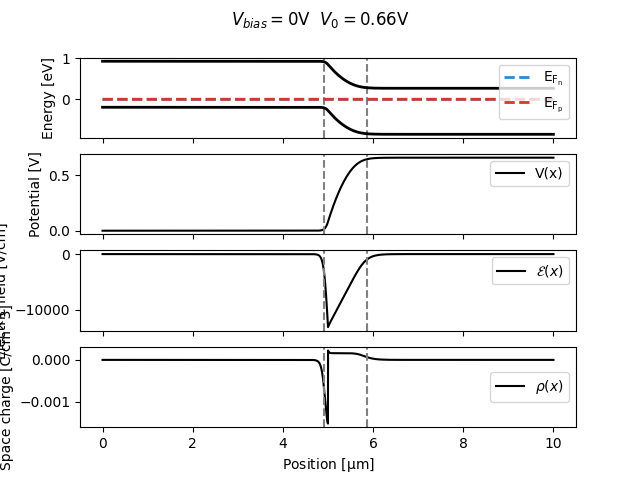

In [74]:
fig, axs = plt.subplots(nrows=4, sharex=True)
# Space charge density
ax = axs[3]
ax.plot(x*1e4, rho, label=r'$\rho(x)$')
ax.set_ylabel(r'Space charge [C/cm^3]')
if DOPING_PROFILE == 'ABRUPT':
    ax.axvline(x=xn0_pos*1e4, ls='--', c='grey')
    ax.axvline(x=xp0_pos*1e4, ls='--', c='grey')
ax.legend(loc='right')

# E field
ax = axs[2]
ax.plot(x*1e4, E, label=r'$\mathcal{E}(x)$')
ax.set_ylabel('Electric field [V/cm]')
if DOPING_PROFILE == 'ABRUPT':
    ax.axvline(x=xn0_pos*1e4, ls='--', c='grey')
    ax.axvline(x=xp0_pos*1e4, ls='--', c='grey')
ax.legend()

ax = axs[1]
ax.set_ylabel('Potential [V]')
ax.plot(x*1e4, v, label='V(x)')
if DOPING_PROFILE == 'ABRUPT':
    ax.axvline(x=xn0_pos*1e4, ls='--', c='grey')
    ax.axvline(x=xp0_pos*1e4, ls='--', c='grey')
ax.legend()

# Band Diagram
ax = axs[0]
if DOPING_PROFILE == 'ABRUPT':
    ax.axvline(x=xn0_pos*1e4, ls='--', c='grey')
    ax.axvline(x=xp0_pos*1e4, ls='--', c='grey')
az.band_diagram((p1, p2), ax=ax)

axs[-1].set_xlabel(r'Position [$\mathregular{\mu m}$]')
fig.suptitle(r'$V_{bias}=$' + f'{bias_voltage}V' + r'  $V_{0}=$' + f'{V0:.2f}V')

### Minority Carrier Concentration

Text(0.5, 1.0, 'Minority Carrier Concentrations')

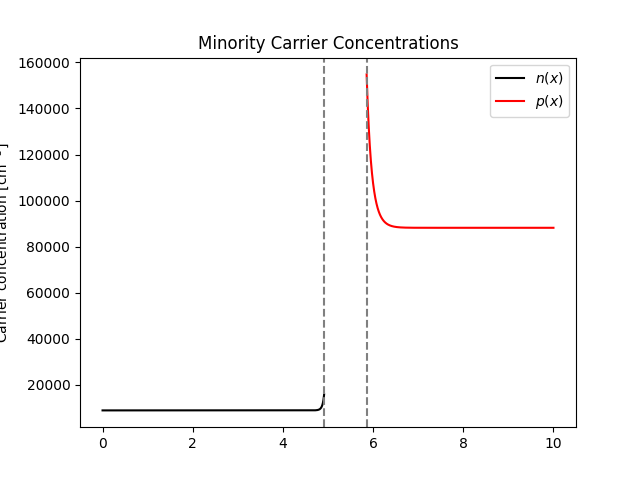

In [75]:
fig, ax = plt.subplots(nrows=1)
if DOPING_PROFILE == 'ABRUPT':
    # Plot n_p
    ax.plot(x[x<xp0_pos]*1e4, n[x<xp0_pos], label=r'$n(x)$')
    # Plot p_n
    ax.plot(x[x>xn0_pos]*1e4, p[x>xn0_pos], label=r'$p(x)$')
    ax.axvline(x=xn0_pos*1e4, ls='--', c='grey')
    ax.axvline(x=xp0_pos*1e4, ls='--', c='grey')
else:
    # Plot n_p
    ax.plot(x[x<junction]*1e4, n[x<junction], label=r'$n(x)$')
    # Plot p_n
    ax.plot(x[x>junction]*1e4, p[x>junction], label=r'$p(x)$')
ax.set_ylabel(r'Carrier concentration [cm$^{-3}$]')
ax.legend()
ax.set_title('Minority Carrier Concentrations')


### Normalized Current Components

In [76]:
# It does not make sense to do this plot in equilibrium
if bias_voltage > 0:
    fig, ax = plt.subplots(nrows=1)
    ax.plot(x*1e4, Jn/(Jp+Jn), label='Electron current')
    ax.plot(x*1e4, Jp/(Jp+Jn), label='Hole current')
    ax.set_ylabel('Normalized current')
    if DOPING_PROFILE == 'ABRUPT':
        ax.axvline(x=xn0_pos*1e4, ls='--', c='grey')
        ax.axvline(x=xp0_pos*1e4, ls='--', c='grey')
    ax.legend()
    ax.set_title('Normalized Current Components')


### Hole and Electron Drift and Diffusion Current Components

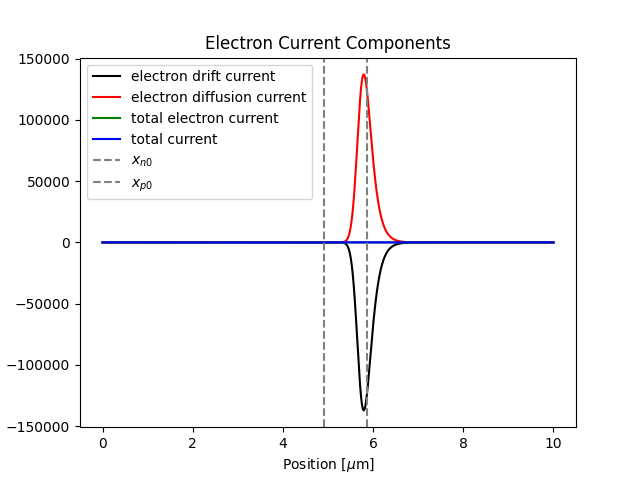

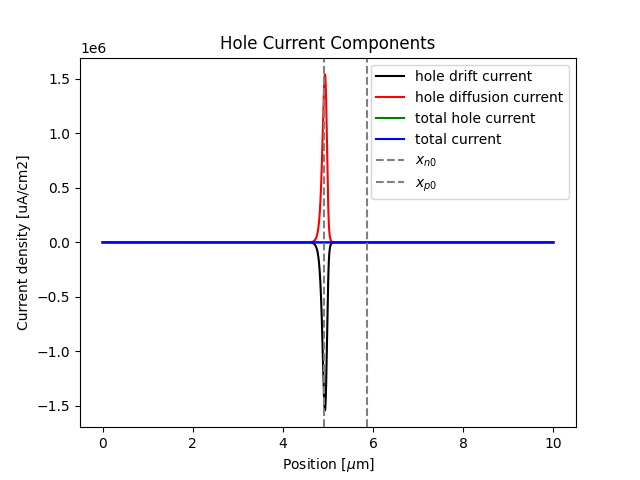

In [77]:
scale = 1e6
plt.figure()
plt.plot(x*1e4, Jn_drift*scale, label='electron drift current')
plt.plot(x*1e4, Jn_diff*scale, label='electron diffusion current')
plt.plot(x*1e4, Jn*scale, label='total electron current')
plt.plot(x*1e4, (Jp+Jn)*scale, label='total current')
plt.xlabel(r'Position [$\mu$m]')
plt.ylabel('Current density [uA/cm2]')
if DOPING_PROFILE == 'ABRUPT':
    plt.axvline(x=xn0_pos*1e4, ls='--', label=r'$x_{n0}$', c='grey')
    plt.axvline(x=xp0_pos*1e4, ls='--', label=r'$x_{p0}$', c='grey')
plt.title('Electron Current Components')
plt.legend()

plt.figure()
plt.plot(x*1e4, Jp_drift*scale, label='hole drift current')
plt.plot(x*1e4, Jp_diff*scale, label='hole diffusion current')
plt.plot(x*1e4, Jp*scale, label='total hole current')
plt.plot(x*1e4, (Jp+Jn)*scale, label='total current')
if DOPING_PROFILE == 'ABRUPT':
    plt.axvline(x=xn0_pos*1e4, ls='--', label=r'$x_{n0}$', c='grey')
    plt.axvline(x=xp0_pos*1e4, ls='--', label=r'$x_{p0}$', c='grey')
plt.xlabel(r'Position [$\mu$m]')
plt.ylabel('Current density [uA/cm2]')
plt.title('Hole Current Components')

plt.legend()